# Project : Walmart TripType Classification


<img src="walmart_competition.jpg">

# 1. Data Introduce
### 1.1 Purpose : Use market basket analysis to classify shopping trips
    

### 1.2 Data set:
   > - Train Data : 647054 rows, 7 columns

   > - Test Data  : 653646 rows, 6 columns
   
   > - Submission Data  : 95674 rows, 39 columns
      
   > - [Source Link : Walmart TripType : Recruiting-trip-type-classification](https://www.kaggle.com/c/walmart-recruiting-trip-type-classification)

### 1.3 Evaluation
   > - multi-class logarithmic loss
   > $$-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij})$$


### 1.4 Results
#### (1) Train-test outcome ( round til 2)
   > - Logarithmic loss : 0.89
   > - Accuracy score : 0.72
#### (2) Kaggle submission
   > - Total Teams : 294
   > - Final Score : 0.79214
   > - Leaderboard :  298
   

### 1.5 Contents
#### (1) Data Format
   > - Column Description
   > - Visualization
#### (2) Feature Engineering
   > - Columns what we made
#### (3) Modeling
   > - The model we tried
   > - The model we ultimately used
#### (4) Feedback 
   > - Question

# Data Format

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from IPython.display import Markdown

# Import the functions used in this project
import new_Exploration.awesome_functions as af
import decode_utils as du
from feature_engineering import *  
from IPython.display import Image
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , log_loss
from sklearn.ensemble import RandomForestClassifier

# Pretty display for notebooks
%matplotlib inline

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

import lightgbm
from scipy.sparse import csr_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 원본을 유지하기 위해서 카피
# df_train = pd.read_csv("../asset/train.csv")
# df_test = pd.read_csv("../asset/test.csv")
# df_submission = pd.read_csv("../asset/sample_submission.csv")

# df_train_dd = pd.read_csv("Feature_matrix/df_train_dd_201807291831.csv")
# df_train_fl = pd.read_csv("Feature_matrix/df_train_fl_201807291845.csv")
# df_train_cp = pd.read_csv("Feature_matrix/df_train_cp_201808062200.csv")

In [46]:
train = pd.read_csv('new_Exploration/train.csv')
test = pd.read_csv('new_Exploration/test.csv')
submission = pd.read_csv('new_Exploration/sample_submission.csv')

In [34]:
display(Markdown('## Train DataFrame'))
display(train.tail())
display(Markdown('## Test DataFrame'))
display(test.tail())

## Train DataFrame

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


## Test DataFrame

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
653641,191348,Sunday,6.657211e+10,1,BATH AND SHOWER,1505.0
653642,191348,Sunday,8.818139e+10,1,BATH AND SHOWER,1099.0
653643,191348,Sunday,4.282557e+09,1,MENS WEAR,8220.0
653644,191348,Sunday,8.046919e+10,1,SWIMWEAR/OUTERWEAR,114.0
653645,191348,Sunday,7.871536e+09,1,MENS WEAR,4923.0


In [35]:
submission = pd.read_csv('new_Exploration/sample_submission.csv')
submission.tail()

,VisitNumber,TripType_3,TripType_4,TripType_5,TripType_6,TripType_7,TripType_8,TripType_9,TripType_12,TripType_14,...,TripType_36,TripType_37,TripType_38,TripType_39,TripType_40,TripType_41,TripType_42,TripType_43,TripType_44,TripType_999
95669,191338,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95670,191339,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95671,191340,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95672,191341,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95673,191348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Brief Column Description

| Index | Feature               | Feature Description                                  | Unique Value |
|-------|-----------------------|------------------------------------------------------|--------|
| 1     | TripType              | 고객의 구매성향을 나타내는 카테고리 값               | 38     |
| 2     | VisitNumber           | 단일 고객의 단일 구매활동을 대표하는 아이디          | 95674  |
| 3     | Weekday               | 구매활동이 발생한 요일                               | 7      |
| 4     | Upc                   | 구매한 Item의 코드 (Universal Product Code)          | 97715  |
| 5     | ScanCount             | 구매된 Item 개수, 음수값은 반품                      | 39     |
| 6     | DepartmentDescription | Item 분류의 가장 높은 범주                           | 69     |
| 7     | FinelineNumber        | 월마트에서 자체적으로 제공하는 더 세분화된 Item 분류 | 5196   |

# EDA

## Distribution of goods by TripType

In [36]:
train.tail()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0
647053,8,191347,Sunday,3.800060e+09,1,GROCERY DRY GOODS,3600.0


In [37]:
train_34 = train[train['TripType']==34]
train_34_groupby = train_34.groupby('DepartmentDescription',as_index=False)['ScanCount'].count()
train_34_groupby = train_34_groupby.sort_values('ScanCount',ascending=False)
train_41 = train[train['TripType']==41]
train_41_groupby = train_41.groupby('DepartmentDescription',as_index=False)['ScanCount'].count()
train_41_groupby = train_41_groupby.sort_values('ScanCount',ascending=False)

Text(0.5,1,'Distribution of DD at TripType = 34')

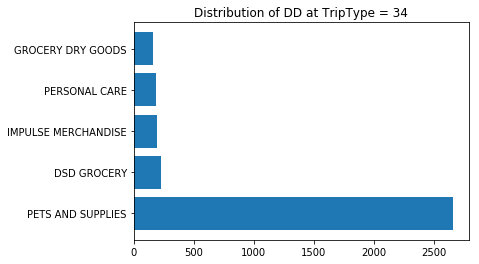

In [38]:
import matplotlib.pyplot as plt
plt.barh((train_34_groupby['DepartmentDescription'][:5]) , (train_34_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 34')

Text(0.5,1,'Distribution of DD at TripType = 41')

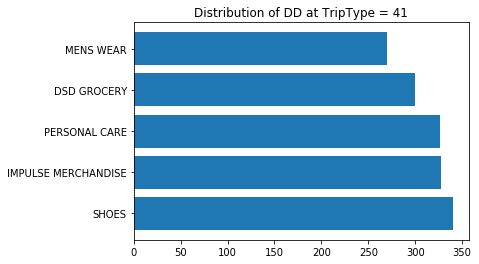

In [39]:
plt.barh((train_41_groupby['DepartmentDescription'][:5]) , (train_41_groupby['ScanCount'][:5]))
plt.title('Distribution of DD at TripType = 41')

### FinelineNumber Case

Text(0.5,1,'Distribution of FL at TripType = 41')

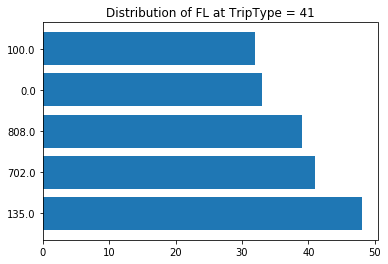

In [74]:
plt.barh((train_41_groupby2['FinelineNumber'][:5].values.astype('str'))\
         , (train_41_groupby2['ScanCount'][:5].values.astype('int')))
plt.title('Distribution of FL at TripType = 41')

## `일부` TripType은 특정 아이템을 많이 산다. 즉, DepartmentDescription 분포(특성) 를 띈다.

## TripType '999' indicating other items

In [40]:
train_tt_sc = train.groupby('TripType',as_index=False)['ScanCount'].sum()

### ▶ TripType 999 : 최종 구매 활동이 음수, '반환'인 유일한 컬럼이다.

### → 'Return' column 추가

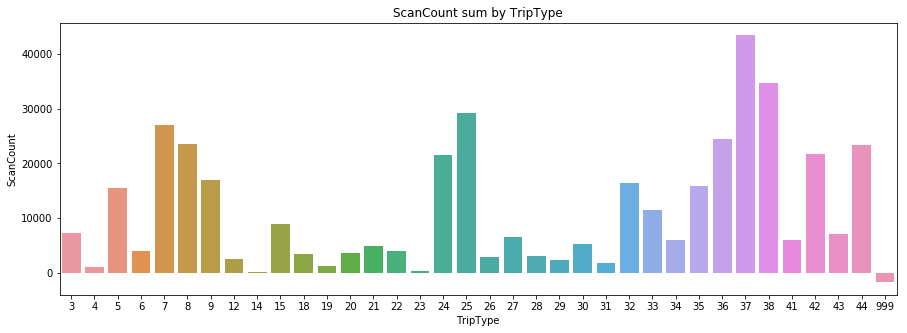

In [41]:
c = train.groupby(['TripType']).sum()['ScanCount'].reset_index()
display(Markdown("### ▶ TripType 999 : 최종 구매 활동이 음수, '반환'인 유일한 컬럼이다."))
display(Markdown("### → \'Return\' column 추가"))
plt.figure(figsize=(15,5))
plt.title('ScanCount sum by TripType')
sns.barplot(x='TripType', y='ScanCount', data=c[c["TripType"].isin([39,40])==False])
plt.show()

In [42]:
train = train.groupby(["TripType", "VisitNumber"]).sum()["ScanCount"].reset_index()
train = train.drop(index=train[train["ScanCount"] >= 0].index)
display(len(train))
train.groupby('TripType').count()['VisitNumber'].reset_index()

4395

,TripType,VisitNumber
0,22,1
1,35,1
2,38,1
3,999,4392


In [97]:
display(train[train['VisitNumber']==5546])
display(train[train['VisitNumber']==80542])
display(train[train['VisitNumber']==136530])
display(train[train['VisitNumber']==190292])
display(train[train['VisitNumber']==190502])

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
17148,22,5546,Friday,6.811315e+10,1,1-HR PHOTO,150.0
17149,22,5546,Friday,6.811315e+10,-2,1-HR PHOTO,150.0


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
270466,35,80542,Wednesday,8.768400e+09,1,DSD GROCERY,4624.0
270467,35,80542,Wednesday,8.768400e+09,-9,DSD GROCERY,4624.0
270468,35,80542,Wednesday,6.827474e+09,5,DSD GROCERY,2351.0
270469,35,80542,Wednesday,8.768400e+09,2,DSD GROCERY,4624.0
270470,35,80542,Wednesday,8.768400e+09,-1,DSD GROCERY,4624.0


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
457789,38,136530,Friday,7.514001e+09,1,DSD GROCERY,9206.0
457790,38,136530,Friday,9.503000e+03,1,DSD GROCERY,9225.0
457791,38,136530,Friday,9.518801e+09,1,DSD GROCERY,4644.0
457792,38,136530,Friday,7.514001e+09,-4,DSD GROCERY,9206.0


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
642759,999,190292,Sunday,8.745860e+10,1,IMPULSE MERCHANDISE,8023.0
642760,999,190292,Sunday,5.114135e+09,-2,HARDWARE,2301.0
642761,999,190292,Sunday,5.114135e+09,-2,HARDWARE,2301.0
642762,999,190292,Sunday,5.114137e+09,-1,HARDWARE,2301.0


,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
643446,999,190502,Sunday,7.314929e+09,-1,HOME MANAGEMENT,6643.0
643447,999,190502,Sunday,7.283831e+09,-1,OFFICE SUPPLIES,3606.0
643448,999,190502,Sunday,8.050404e+10,-1,SHOES,8430.0


### TripType 999에 속한 구매자들은 최종 구매활동이 `환불` 인 강한 경향성을 띄고 있다.

## Deal with Missing value

In [98]:
train.isna().sum()

TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

In [100]:
null_index = sorted(list(set(train[train['Upc'].isna()].index).intersection(set(train[train['FinelineNumber'].isna()].index))))
null_train_df = train.loc[null_index,:]#.reset_index(drop=True)

In [48]:
null_train_df['DepartmentDescription'].value_counts().reset_index()

,index,DepartmentDescription
0,PHARMACY RX,2768


In [267]:
null_train_df.iloc[:10,:]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
25,26,8,Friday,NaN,1,NaN,NaN
548,27,259,Friday,NaN,3,NaN,NaN
549,27,259,Friday,NaN,1,NaN,NaN
959,999,409,Friday,NaN,-1,NaN,NaN
1116,39,479,Friday,NaN,1,NaN,NaN
1134,999,484,Friday,NaN,-2,NaN,NaN
1135,999,484,Friday,NaN,-2,NaN,NaN
1155,44,496,Friday,NaN,1,PHARMACY RX,NaN
1216,5,521,Friday,NaN,1,PHARMACY RX,NaN
1373,5,585,Friday,NaN,1,PHARMACY RX,NaN


> - FinelineNumber와 Upc 컬럼이 결측치인 경우, DepartmentDescription 컬럼은 함께 결측치를 띄거나 `PHARMACY RX`이다.

### Imputation on FinelineNumber , Upc

In [268]:
null_train_df

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
25,26,8,Friday,NaN,1,NaN,NaN
548,27,259,Friday,NaN,3,NaN,NaN
549,27,259,Friday,NaN,1,NaN,NaN
959,999,409,Friday,NaN,-1,NaN,NaN
1116,39,479,Friday,NaN,1,NaN,NaN
1134,999,484,Friday,NaN,-2,NaN,NaN
1135,999,484,Friday,NaN,-2,NaN,NaN
1155,44,496,Friday,NaN,1,PHARMACY RX,NaN
1216,5,521,Friday,NaN,1,PHARMACY RX,NaN
1373,5,585,Friday,NaN,1,PHARMACY RX,NaN


In [278]:
ls1 = train[train['DepartmentDescription']=='PHARMACY RX'].index
ls2 = null_train_df[null_train_df['DepartmentDescription']=='PHARMACY RX'].index
ls3 = list(set(ls1).difference(set(ls2)))
most_freq_pharmacy_rx = train.loc[ls3,:]
most_feq_upc = most_freq_pharmacy_rx['Upc']
most_feq_fl = most_freq_pharmacy_rx['FinelineNumber']
most_feq_upc = most_feq_upc.value_counts().index[0]
most_feq_fl = most_feq_fl.value_counts().index[0]

In [285]:
most_feq_upc , most_feq_fl

(30169183702.0, 4822.0)

### DepartmentDescription 컬럼이  `PHARMACY RX` 이고, 나머지 아이템 컬럼이 결측치일 때, 위의 두 가지 코드로 채워준다.

### 세 가지 아이템 컬럼이 모두 결측치를 띄는 경우에는, 아래의 값으로 Imputation 한다.
> - DepartmentDescription: NULL 

> - FinelineNumber: 1.1 

> - Upc: -9999 respectively.

## Our initial hypothesis after EDA
> ### (1) TripType 이 정해지는 데에 가장 중요한 요소는 `어떠한 아이템을 샀는가`이다.
> ### (2) 구매자들 즉, VisitNumber 마다 각기 구분되는 `구매 패턴`을 띄고 있다.
> ### (3)  즉, 고유한 VisitNumber가 가지고 있는 잘 나오는 `주사위 면`을 가지고 있고, 이에 따라 라벨이 정해진다.

# Feature Engineering
- 1) UPC decoding
- 2) Feature what we used

## UPC Decoding
- https://www.kaggle.com/c/walmart-recruiting-trip-type-classification/discussion/18158

<img src="upc_decoding.jpg">

- 만약 Upc가 결측치라면 -9999를 채워준다.
- There are some products in the dataset with a length of 4 or 5. It seemed that these are the in-house products (PRODUCE)
- 코드의 길이가 5 이하라면. 월마트 내부에서 자체적으로 생산하는 물품인 경우로 보여진다.(HOUSE)

In [234]:
print('Before Decoding: ',len(train['Upc'].unique()))
print('After Decoding: ',len(decodeStuffNeedsToBeDecoded(train)['Company'].unique()))

Before Decoding:  97715
After Decoding:  5687


### Feature What we MADE and USED

| Index | Feature               | Feature Description                                  |
|-------|-----------------------|------------------------------------------------------|
| 1     | DepartmentDescription_dummies              | DepartmentDescription 더미화               | 
| 2     | FinelineNumber_dummies           | FinelineNumber 더미화          | 
| 3     | Company_dummies               | Company 더미화                               |
| 4     | Item_dummies                   | Item 더미화          |
| 5     | Weekday_dummies             | Weekday 더미화                      |
| 6     | N_DD/FL/COMP | VisitNumber 별 item의 Unique_count       |
| 7     | Scancount_total        | VisitNumber 별 ScanCount Total Sum |

### UPC, FinelineNumber, DepartmentDescription 결측치 처리 및 Decoding을 통해서 COMPANY, ITEM_NBR을 추가함.

In [75]:
df_decoded = du.decodeStuffNeedsToBeDecoded(df_train)

### Item_nbr는 총 10007개의 unique값을 가지므로, df를 저장해서 불러오지않고, 직접 pivot을 실행했다.

In [100]:
%time df_train_item = get_pivor_df(df_decoded, "Item_nbr")
df_train_item = df_train_item.reset_index()

CPU times: user 1min 48s, sys: 1min 1s, total: 2min 49s
Wall time: 2min 57s


### cp, fl, item 컬럼들을 전체 사용하지않고, 1개의 dd를 바라보는 아이템들만 list로 가져왔다.

In [91]:
sc_li, cp_li, fl_li, item_li = getRelevantListWeNeed(df_decoded)
len(cp_li), len(fl_li), len(item_li)

(4806, 2696, 9958)

### Visitnumber 당 구매한 카테고리 갯수를 컬럼별로 저장

In [92]:
num_dd = get_num_of_categories_per_users(df_decoded)
num_fl = get_num_of_categories_per_users(df_decoded, "FinelineNumber")
num_company = get_num_of_categories_per_users(df_decoded, "Company")
num_upc = get_num_of_categories_per_users(df_decoded, "Upc")
num_item = get_num_of_categories_per_users(df_decoded, "Item_nbr")
len(num_dd), len(num_fl), len(num_company), len(num_dd), len(num_dd)

(95674, 95674, 95674, 95674, 95674)

In [44]:
df_train_fl.rename({"-1" : "1.1"}, axis=1, inplace=True)

In [101]:
%time dfs = [df_train_fl[fl_li], df_train_cp[cp_li], df_train_item[item_li]]

CPU times: user 16.2 s, sys: 29.4 s, total: 45.5 s
Wall time: 50 s


### fl, cp는 median 값이상, item은 mean 값이상인 컬럼들만 남김

In [103]:
col_fl_filttered_li, col_cp_filttered_li, col_item_filttered_li = get_filttered_list_by_cols(dfs)

In [104]:
print(len(col_fl_filttered_li) + len(col_cp_filttered_li) + len(col_item_filttered_li))
len(col_cp_filttered_li), len(col_fl_filttered_li), len(col_item_filttered_li), 

6333


(2360, 1360, 2613)

In [105]:
df_feature = pd.concat([df_train_dd, df_train_fl[col_fl_filttered_li],\
                   df_train_item[col_item_filttered_li], df_train_cp[col_cp_filttered_li]], axis = 1)
len(df_feature)

95674

### DepartmentDescription의 MENSWEAR, MENS WEAR 컬럼은 의미가 같으므로 합쳐준다.

In [106]:
df_feature["MENSWEAR"] = df_feature["MENS WEAR"] + df_feature["MENSWEAR"]
df_feature.drop("MENS WEAR", axis = 1, inplace=True)

### 각 VisitNumber 당 Scan한 총합을 추가.

In [107]:
df_feature["Scancount_total"] = sc_li

### Number 관련 컬럼 만들기

In [108]:
df_feature["N_DD"] = num_dd
df_feature["N_FL"] = num_fl
df_feature["N_COMPANY"] = num_company
df_feature["N_ITEM"] = num_item

In [109]:
df_upc = df_decoded.groupby(["VisitNumber", "Upc"]).sum()["ScanCount"].reset_index(name="Sc_sum")
upc_vn_li = df_upc.groupby("VisitNumber").sum()["Sc_sum"].index.unique()
df_feature.set_index("VisitNumber", inplace=True)
df_feature["N_UPC"] = 0
df_feature.at[upc_vn_li, "N_UPC"] = num_upc
df_feature = df_feature.reset_index()

In [110]:
row_count = df_decoded.groupby("VisitNumber").count()["TripType"].values
df_feature["ROW_CNT"] = row_count

In [111]:
df_feature["FL_DIV_DD"] = df_feature["N_FL"].div(df_feature["N_DD"], axis = 0)
df_feature["UPC_DIV_DD"] = df_feature["N_UPC"].div(df_feature["N_DD"], axis = 0)
df_feature["COMPANY_DIV_DD"] = df_feature["N_COMPANY"].div(df_feature["N_DD"], axis = 0)

In [178]:
df_feature = df_feature.fillna(0)

In [113]:
df_feature[["N_DD", "N_UPC", "N_FL", "N_ITEM", "ROW_CNT", "Scancount_total"]].describe()

,N_DD,N_UPC,N_FL,N_ITEM,ROW_CNT,Scancount_total
count,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000,95674.000000
mean,3.298043,6.424818,5.824372,6.394924,6.763112,7.499467
std,2.932498,8.378746,7.359822,8.220524,8.531894,10.261119
min,0.000000,0.000000,0.000000,0.000000,1.000000,-52.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000
50%,2.000000,3.000000,3.000000,3.000000,4.000000,4.000000
75%,5.000000,8.000000,7.000000,8.000000,8.000000,9.000000
max,26.000000,189.000000,112.000000,186.000000,209.000000,311.000000


In [197]:
%time df_feature = pd.DataFrame(np.where(df_feature == np.inf, 0, df_feature), columns=df_feature.columns)
%time df_feature = pd.DataFrame(np.where(df_feature == -np.inf, 0, df_feature), columns=df_feature.columns)

CPU times: user 3.02 s, sys: 2.34 s, total: 5.36 s
Wall time: 5.38 s
CPU times: user 3.98 s, sys: 5.49 s, total: 9.47 s
Wall time: 10.7 s


In [115]:
df_feature.head()

,VisitNumber,TripType,Return,1-HR PHOTO,ACCESSORIES,AUTOMOTIVE,BAKERY,BATH AND SHOWER,BEAUTY,BEDDING,...,Scancount_total,N_DD,N_FL,N_COMPANY,N_ITEM,N_UPC,ROW_CNT,FL_DIV_DD,UPC_DIV_DD,COMPANY_DIV_DD
0,5.0,999.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000
1,7.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.000000,1.0,1.000000
2,8.0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,7.0,17.0,15.0,20.0,21.0,23.0,2.428571,3.0,2.142857
3,9.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,3.0,3.0,3.0,3.0,3.0,1.500000,1.5,1.500000
4,10.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,3.0,3.0,3.0,3.0,3.0,1.500000,1.5,1.500000


# Modeling
- Logistic Regression
- Random Forest Decision Tree
- Light GBM

In [147]:
from sklearn.externals import joblib

In [148]:
def saveModelObjectAsPickle(model, fileName):
    joblib.dump(model, fileName)

In [137]:
def run_light_gbm(df_feature):
    train_X , train_y = af.get_df_to_fit(df_feature)
    label_enc = LabelEncoder().fit(train_y)
    y_labeled = label_enc.transform(train_y)
    train_X, test_X, train_y, test_y = train_test_split(train_X, y_labeled, random_state=0)
    print("Splited train data in two")
    train_X = train_X.astype(float)
    test_X = test_X.astype(float)
    X_train = csr_matrix(train_X.values)
    X_test = csr_matrix(test_X.values)
    dtrain = lightgbm.Dataset(X_train, label=train_y)
    dtest = lightgbm.Dataset(X_test, label=test_y)
    print("Dataset has been made")
    num_boost_round = 4000
    learning_rate=0.02

    params = {'objective':'multiclass',
              'boosting_type': 'gbdt',
              'max_depth' : -1,
              'nthread': 4,
              'metric': 'multi_logloss',
              'num_class':38,
              'learning_rate':learning_rate,
              }

    # evals = [(dtrain, 'train'), (dtest, 'test')]

    # %%time
    # 4000, 0.008
    lightgbm_model = lightgbm.train(params = params,
                                    train_set = dtrain, 
                                    valid_sets = [dtrain, dtest],
                                    num_boost_round = num_boost_round,
                                    early_stopping_rounds=10)
    
    return lightgbm_model

In [119]:
num_boost_round = 4000
learning_rate=0.02

params = {'objective':'multiclass',
          'boosting_type': 'gbdt',
          'max_depth' : -1,
          'nthread': 4,
          'metric': 'multi_logloss',
          'num_class':38,
          'learning_rate':learning_rate,
          }

# evals = [(dtrain, 'train'), (dtest, 'test')]

# %%time
# 4000, 0.008
lightgbm_model = lightgbm.train(params = params,
                                train_set = dtrain, 
                                valid_sets = [dtrain, dtest],
                                num_boost_round = num_boost_round,
                                early_stopping_rounds=10)

[1]	training's multi_logloss: 3.43094	valid_1's multi_logloss: 3.4364
Training until validation scores don't improve for 10 rounds.
[2]	training's multi_logloss: 3.27408	valid_1's multi_logloss: 3.28393
[3]	training's multi_logloss: 3.14513	valid_1's multi_logloss: 3.15806
[4]	training's multi_logloss: 3.03543	valid_1's multi_logloss: 3.0513
[5]	training's multi_logloss: 2.93908	valid_1's multi_logloss: 2.95748
[6]	training's multi_logloss: 2.85334	valid_1's multi_logloss: 2.87412
[7]	training's multi_logloss: 2.77557	valid_1's multi_logloss: 2.79837
[8]	training's multi_logloss: 2.70458	valid_1's multi_logloss: 2.72928
[9]	training's multi_logloss: 2.63909	valid_1's multi_logloss: 2.66547
[10]	training's multi_logloss: 2.57849	valid_1's multi_logloss: 2.60666
[11]	training's multi_logloss: 2.52209	valid_1's multi_logloss: 2.55165
[12]	training's multi_logloss: 2.4694	valid_1's multi_logloss: 2.50054
[13]	training's multi_logloss: 2.41988	valid_1's multi_logloss: 2.45242
[14]	training'

[115]	training's multi_logloss: 0.968245	valid_1's multi_logloss: 1.07574
[116]	training's multi_logloss: 0.963756	valid_1's multi_logloss: 1.07175
[117]	training's multi_logloss: 0.959309	valid_1's multi_logloss: 1.0678
[118]	training's multi_logloss: 0.954944	valid_1's multi_logloss: 1.06393
[119]	training's multi_logloss: 0.950583	valid_1's multi_logloss: 1.06012
[120]	training's multi_logloss: 0.946272	valid_1's multi_logloss: 1.05631
[121]	training's multi_logloss: 0.942084	valid_1's multi_logloss: 1.0526
[122]	training's multi_logloss: 0.937973	valid_1's multi_logloss: 1.04899
[123]	training's multi_logloss: 0.933893	valid_1's multi_logloss: 1.04538
[124]	training's multi_logloss: 0.929863	valid_1's multi_logloss: 1.04186
[125]	training's multi_logloss: 0.925924	valid_1's multi_logloss: 1.03842
[126]	training's multi_logloss: 0.922017	valid_1's multi_logloss: 1.03503
[127]	training's multi_logloss: 0.918159	valid_1's multi_logloss: 1.03173
[128]	training's multi_logloss: 0.91433	

[225]	training's multi_logloss: 0.687205	valid_1's multi_logloss: 0.84945
[226]	training's multi_logloss: 0.68577	valid_1's multi_logloss: 0.848474
[227]	training's multi_logloss: 0.684355	valid_1's multi_logloss: 0.847526
[228]	training's multi_logloss: 0.682949	valid_1's multi_logloss: 0.846564
[229]	training's multi_logloss: 0.681533	valid_1's multi_logloss: 0.845655
[230]	training's multi_logloss: 0.680156	valid_1's multi_logloss: 0.844716
[231]	training's multi_logloss: 0.678772	valid_1's multi_logloss: 0.84378
[232]	training's multi_logloss: 0.677388	valid_1's multi_logloss: 0.842862
[233]	training's multi_logloss: 0.676032	valid_1's multi_logloss: 0.841948
[234]	training's multi_logloss: 0.674684	valid_1's multi_logloss: 0.841038
[235]	training's multi_logloss: 0.673352	valid_1's multi_logloss: 0.840172
[236]	training's multi_logloss: 0.672026	valid_1's multi_logloss: 0.839316
[237]	training's multi_logloss: 0.670671	valid_1's multi_logloss: 0.838436
[238]	training's multi_loglo

[335]	training's multi_logloss: 0.571679	valid_1's multi_logloss: 0.784331
[336]	training's multi_logloss: 0.570916	valid_1's multi_logloss: 0.784007
[337]	training's multi_logloss: 0.570141	valid_1's multi_logloss: 0.783709
[338]	training's multi_logloss: 0.56935	valid_1's multi_logloss: 0.783373
[339]	training's multi_logloss: 0.568577	valid_1's multi_logloss: 0.783014
[340]	training's multi_logloss: 0.567805	valid_1's multi_logloss: 0.782721
[341]	training's multi_logloss: 0.567029	valid_1's multi_logloss: 0.782379
[342]	training's multi_logloss: 0.566262	valid_1's multi_logloss: 0.782041
[343]	training's multi_logloss: 0.565517	valid_1's multi_logloss: 0.781732
[344]	training's multi_logloss: 0.564763	valid_1's multi_logloss: 0.781433
[345]	training's multi_logloss: 0.56402	valid_1's multi_logloss: 0.781132
[346]	training's multi_logloss: 0.563277	valid_1's multi_logloss: 0.780807
[347]	training's multi_logloss: 0.562513	valid_1's multi_logloss: 0.780492
[348]	training's multi_logl

[445]	training's multi_logloss: 0.499071	valid_1's multi_logloss: 0.757873
[446]	training's multi_logloss: 0.498521	valid_1's multi_logloss: 0.757748
[447]	training's multi_logloss: 0.497974	valid_1's multi_logloss: 0.757574
[448]	training's multi_logloss: 0.497396	valid_1's multi_logloss: 0.757397
[449]	training's multi_logloss: 0.496853	valid_1's multi_logloss: 0.757224
[450]	training's multi_logloss: 0.49627	valid_1's multi_logloss: 0.757023
[451]	training's multi_logloss: 0.495722	valid_1's multi_logloss: 0.756849
[452]	training's multi_logloss: 0.49517	valid_1's multi_logloss: 0.756658
[453]	training's multi_logloss: 0.494602	valid_1's multi_logloss: 0.756477
[454]	training's multi_logloss: 0.494045	valid_1's multi_logloss: 0.756307
[455]	training's multi_logloss: 0.493499	valid_1's multi_logloss: 0.756172
[456]	training's multi_logloss: 0.492962	valid_1's multi_logloss: 0.756017
[457]	training's multi_logloss: 0.492425	valid_1's multi_logloss: 0.75587
[458]	training's multi_loglo

[555]	training's multi_logloss: 0.445654	valid_1's multi_logloss: 0.744117
[556]	training's multi_logloss: 0.445219	valid_1's multi_logloss: 0.744033
[557]	training's multi_logloss: 0.444796	valid_1's multi_logloss: 0.743953
[558]	training's multi_logloss: 0.444377	valid_1's multi_logloss: 0.743874
[559]	training's multi_logloss: 0.443945	valid_1's multi_logloss: 0.743776
[560]	training's multi_logloss: 0.443524	valid_1's multi_logloss: 0.743679
[561]	training's multi_logloss: 0.443106	valid_1's multi_logloss: 0.743565
[562]	training's multi_logloss: 0.442688	valid_1's multi_logloss: 0.743492
[563]	training's multi_logloss: 0.442272	valid_1's multi_logloss: 0.743414
[564]	training's multi_logloss: 0.44185	valid_1's multi_logloss: 0.743318
[565]	training's multi_logloss: 0.441437	valid_1's multi_logloss: 0.743223
[566]	training's multi_logloss: 0.441006	valid_1's multi_logloss: 0.743124
[567]	training's multi_logloss: 0.440604	valid_1's multi_logloss: 0.743054
[568]	training's multi_log

[665]	training's multi_logloss: 0.403794	valid_1's multi_logloss: 0.736347
[666]	training's multi_logloss: 0.403452	valid_1's multi_logloss: 0.736322
[667]	training's multi_logloss: 0.403107	valid_1's multi_logloss: 0.736272
[668]	training's multi_logloss: 0.402782	valid_1's multi_logloss: 0.736208
[669]	training's multi_logloss: 0.402449	valid_1's multi_logloss: 0.736155
[670]	training's multi_logloss: 0.402108	valid_1's multi_logloss: 0.736101
[671]	training's multi_logloss: 0.401777	valid_1's multi_logloss: 0.736062
[672]	training's multi_logloss: 0.401448	valid_1's multi_logloss: 0.73603
[673]	training's multi_logloss: 0.401114	valid_1's multi_logloss: 0.735985
[674]	training's multi_logloss: 0.400784	valid_1's multi_logloss: 0.735934
[675]	training's multi_logloss: 0.400434	valid_1's multi_logloss: 0.735879
[676]	training's multi_logloss: 0.400101	valid_1's multi_logloss: 0.735825
[677]	training's multi_logloss: 0.399774	valid_1's multi_logloss: 0.735784
[678]	training's multi_log

[775]	training's multi_logloss: 0.369847	valid_1's multi_logloss: 0.73185
[776]	training's multi_logloss: 0.369562	valid_1's multi_logloss: 0.731811
[777]	training's multi_logloss: 0.369288	valid_1's multi_logloss: 0.731791
[778]	training's multi_logloss: 0.369005	valid_1's multi_logloss: 0.731751
[779]	training's multi_logloss: 0.368729	valid_1's multi_logloss: 0.731723
[780]	training's multi_logloss: 0.368455	valid_1's multi_logloss: 0.731698
[781]	training's multi_logloss: 0.368177	valid_1's multi_logloss: 0.731681
[782]	training's multi_logloss: 0.367902	valid_1's multi_logloss: 0.731653
[783]	training's multi_logloss: 0.367624	valid_1's multi_logloss: 0.73162
[784]	training's multi_logloss: 0.367347	valid_1's multi_logloss: 0.731573
[785]	training's multi_logloss: 0.367069	valid_1's multi_logloss: 0.73155
[786]	training's multi_logloss: 0.366794	valid_1's multi_logloss: 0.73154
[787]	training's multi_logloss: 0.366524	valid_1's multi_logloss: 0.731504
[788]	training's multi_loglos

[885]	training's multi_logloss: 0.341454	valid_1's multi_logloss: 0.729776
[886]	training's multi_logloss: 0.341219	valid_1's multi_logloss: 0.72977
[887]	training's multi_logloss: 0.340979	valid_1's multi_logloss: 0.729743
[888]	training's multi_logloss: 0.340739	valid_1's multi_logloss: 0.729709
[889]	training's multi_logloss: 0.340501	valid_1's multi_logloss: 0.729714
[890]	training's multi_logloss: 0.340265	valid_1's multi_logloss: 0.729702
[891]	training's multi_logloss: 0.340026	valid_1's multi_logloss: 0.729706
[892]	training's multi_logloss: 0.33979	valid_1's multi_logloss: 0.72969
[893]	training's multi_logloss: 0.339557	valid_1's multi_logloss: 0.72968
[894]	training's multi_logloss: 0.339322	valid_1's multi_logloss: 0.729645
[895]	training's multi_logloss: 0.339094	valid_1's multi_logloss: 0.729638
[896]	training's multi_logloss: 0.338866	valid_1's multi_logloss: 0.729637
[897]	training's multi_logloss: 0.33863	valid_1's multi_logloss: 0.729618
[898]	training's multi_logloss

In [102]:
def logis(feature_df):
    train_X , train_y = af.get_df_to_fit(feature_df)
    logis_model = LogisticRegression().fit(train_X, train_y)
    log_score = log_loss(train_y,logis_model.predict_proba(train_X))
    acc_score = accuracy_score(train_y,logis_model.predict(train_X))
    return log_score , acc_score

def random(feature_df):
    train_X , train_y = af.get_df_to_fit(feature_df)
    random_model = RandomForestClassifier(max_depth=17,n_estimators=50).fit(train_X, train_y)
    log_score = log_loss(train_y,random_model.predict_proba(train_X))
    acc_score = accuracy_score(train_y,random_model.predict(train_X))
    return log_score , acc_score

In [202]:
%time log_score , acc_score = logis(df_feature)
log_score, acc_score

CPU times: user 3min 7s, sys: 9.25 s, total: 3min 16s
Wall time: 3min 4s


(0.9636291205290383, 0.7231118172126179)

In [201]:
%time log_score , acc_score = random(df_feature)
log_score, acc_score

CPU times: user 39.4 s, sys: 6.31 s, total: 45.7 s
Wall time: 46.8 s


(1.8159240131062877, 0.5340844952651713)

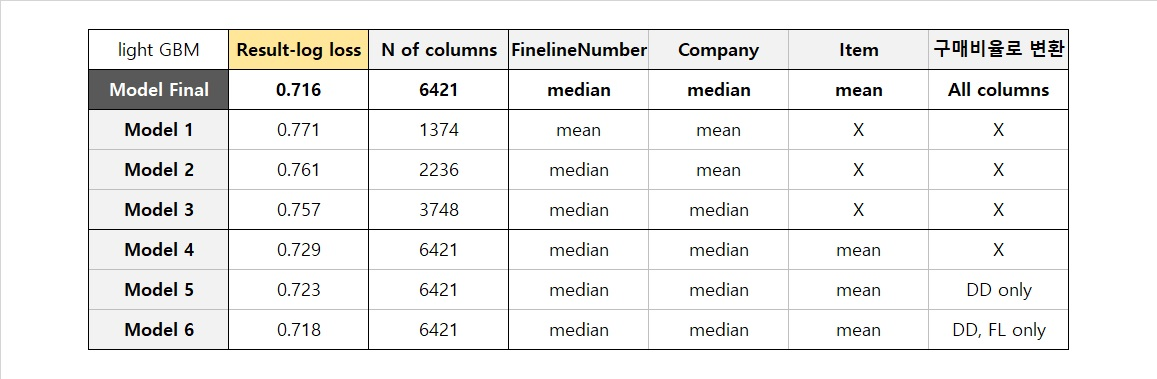

In [3]:
Image("Modeling for Feature Selection.jpg")

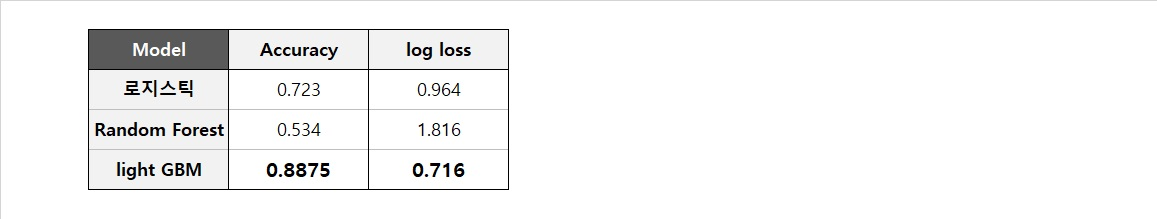

In [18]:
Image("Modeling Selection.jpg")

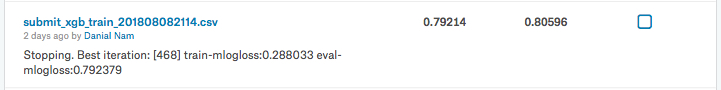

In [101]:
Image("kaggle_score.jpg")